In [2]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
data_path = "train/"

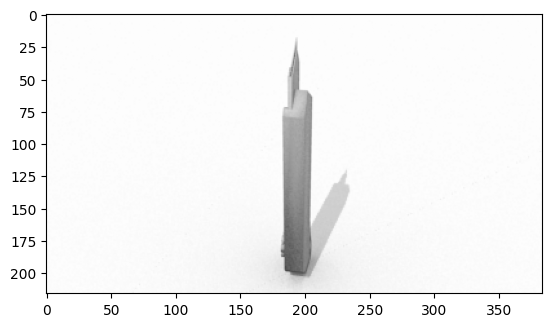

In [42]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((216 ,384))])
train_set = torchvision.datasets.ImageFolder(
    root= data_path, transform=transform
)
batch_size = 64

trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

img = next(iter(trainloader))[0][0]

plt.imshow(img.permute(1, 2, 0).numpy())

In [43]:
class LinearClassifier(torch.nn.Module):
  def __init__(self, input_dim=3*216*384, output_dim=12):
    super(LinearClassifier, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
          x = x.view(x.size(0), -1)
          x = self.linear(x)
          return x

In [44]:
model  = LinearClassifier()
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [45]:
classes = np.arange(0, 12, 1)
dataiter = iter(trainloader)
images, labels = next(dataiter)

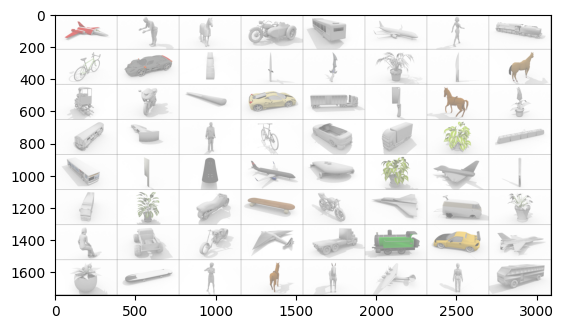

In [46]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0))) #Cette ligne utilise la fonction plt.imshow de Matplotlib pour afficher 
  #l'image. np.transpose(npimg, (1, 2, 0)) transpose les dimensions de l'array NumPy npimg 
  #pour qu'elles correspondent au format attendu par imshow (largeur x hauteur x canaux).
  plt.show()

imshow(torchvision.utils.make_grid(images))

In [47]:
print(labels)

tensor([ 0,  7,  4,  6,  2,  0,  7, 10,  1,  3, 10,  5,  5,  8,  5,  4, 10,  6,
         5,  3, 11,  5,  4,  8, 10,  5,  7,  1,  3, 11,  8, 10,  2,  5,  9,  0,
         9,  8,  0,  5, 11,  8,  6,  9,  6,  0,  2,  8,  7, 11,  6,  0, 11, 10,
         3,  0,  8,  9,  7,  4,  4,  0,  7,  2])


In [48]:
# Conversion de train_set.targets en un tenseur
targets_tensor = torch.tensor(train_set.targets)

# Préparation des étiquettes en one-hot
one_hot_labels = F.one_hot(targets_tensor, num_classes=12).to(torch.long)

# Création du DataLoader avec les étiquettes encodées en one-hot
trainloader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)



all_loss = []
for epoch in range(12):
    temp_loss = []
    for images, labels in trainloader:
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Calculer les sorties du modèle
        output = model(images)
        # Calculer la perte en utilisant les sorties et les étiquettes
        loss = criterion(output, labels)
        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()

        temp_loss.append(loss.item())

    all_loss.append(np.mean(temp_loss))
    print(f"Epoch: {epoch}, loss: {np.mean(temp_loss)}")


Epoch: 0, loss: 26.34207789253328
Epoch: 1, loss: 15.325587695932109
Epoch: 2, loss: 13.162495650432373
Epoch: 3, loss: 12.230461716251549
Epoch: 4, loss: 11.326899077389843
Epoch: 5, loss: 10.91455581016044
Epoch: 6, loss: 10.34453754275912
Epoch: 7, loss: 10.284331555580712
Epoch: 8, loss: 9.838399676842213
Epoch: 9, loss: 9.532847166661952
Epoch: 10, loss: 9.29261049875985
Epoch: 11, loss: 9.117637984498423


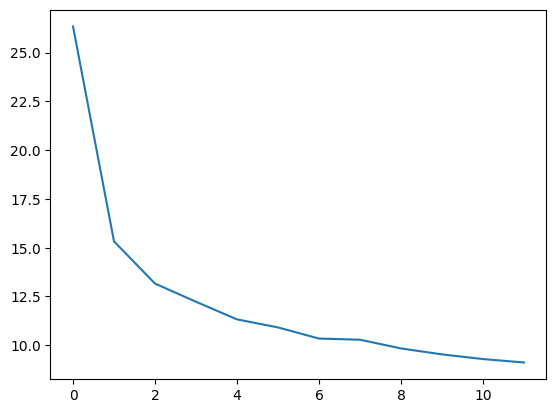

In [49]:
plt.plot(all_loss)

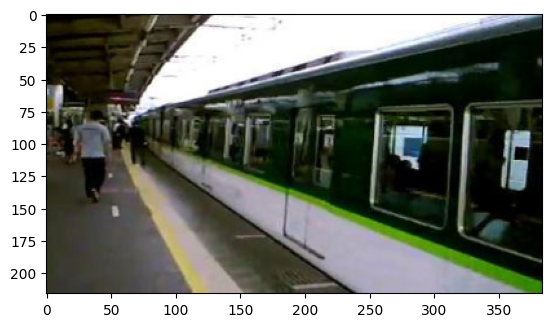

In [52]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Resize((216 ,384))])
test_set = torchvision.datasets.ImageFolder(
    root= 'test', transform=transform
)
batch_size = 64

testloader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=True
)

img = next(iter(testloader))[0][0]

plt.imshow(img.permute(1, 2, 0).numpy())

In [53]:
correct, total = 0, 0

with torch.no_grad():

  for images, labels in testloader:
    output = model(images.view(images.shape[0], -1))

    _, predicted = torch.max(output.data, 1)
    # le _ permet de ne pas prendre en compte le score maximal calculé mais seulement l'indice
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

In [54]:
100 * correct / total

5.014370198419278